In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

Reading the CSV Dataset

In [2]:
data = pd.read_csv("C:/Users/aksin52/Documents/Statistics/bank.csv", na_values =['NA'])

The Business Problem:
    
    "Over a period of time, a loan approval process will start gathering experience about which approved loans gone into default.
    At the start, there was no historical data to build a predictive process in order to cherry pick the loan applications to 
    approve. Decisions were taken based on business understanding and behvaior hypothesis. However, the bank now has enough 
    datapoints and would like you to build a solution to enable more profitable loan approval process".

We explore the data to develop understandign of the undelying behavior features
The data is about various features connected to the loan applicant and their corresponding payment outcomes 
    (whether they had defaulted or not)
We break this down and process the data to enable use of certain ML algorithms (Setting up the Algo to win)

 1. In order for the bank to be profitable they need to avoid giving out risky loans (Loan default is a measure of risk)
 2. if we are able to segregate loan applicants into 2 buckets (Risky and Non Risky) based on their available features, then
    the bank can decide actions accordingly.
 3. Either Loan will not be approved or it will attract a higher rate of interest
 4. The higher rate of interest will be decided by a process called Risk Based Pricing and develop Credit Strategy

What happens when the model is trained - How is it used? 
 1 . Apply the model to generate probabilities of default and basis that classify new applications into Risky/Non Risky
     Ideally in production environment the model will run every time an application is processed. This should be an automated
     process.
        
 2 . Reject Inference (Applying the model on Through the Door Population) - Only for Loan Origination or Customer Acquistion

What Next - how is it improved?
 1. Continous model validation (automated) to check accuracy and stability of the features
 2. Evaluate all likely candidate algorithms to check if the model can be improved

Checking the kind of datapoints provided

In [251]:
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

Printing some observations to get a sense of the nature of captured data

In [252]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [253]:
data.shape

(11162, 17)

In [254]:
data.groupby('default').count()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
default,,,,,,,,,,,,,,,,
no,10994,10994,10994,10994,10994,10994,10994,10994,10994,10994,10994,10994,10994,10994,10994,10994
yes,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168,168


In [3]:
#In case you need to create an 1/0 Target Variable
import numpy as np
data['target']=np.where(data['default']=='no', 0,1)
data['target'].mean()

0.0150510661171833

In [256]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous,target
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557,0.015051
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007,0.121761
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000,0.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000,1.000000


checking the relationship of categorical variables with Default rate. This will give you the probabilities of default
across diffent classes of the categorical variable. If you have a variable that has comparable default rates with the average
default rate, then it may not be a good feature in your model. However, if you have a variable that has default rates across 
categories, out of which some are higher/lower than average defaut rate, then it may be a good predictor

Observations on which variables can be good predictors
Housing - Not good
Job - good 
Loan- good
education - not good

Try to perform Chi Square Goodness of Fit Test to eliminate categorical variables
 H0: There is no statistically significant difference between the default rates
 H1: The difference in default rates across the classes is statistically significant

In [7]:
data.groupby('contact').target.mean()

contact
cellular     0.013056
telephone    0.005168
unknown      0.025149
Name: target, dtype: float64

In [32]:
data['Rank']=pd.qcut(data['balance'].rank(method='first').values,10,duplicates='drop').codes+1
gr_data = data.groupby(['Rank']) 
gr_data.max()
data.groupby('Rank')['target'].mean()

Rank
1     0.080573
2     0.031362
3     0.013441
4     0.008961
5     0.003584
6     0.002688
7     0.007168
8     0.000896
9     0.000896
10    0.000895
Name: target, dtype: float64

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 18 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
target       11162 non-null int32
dtypes: int32(1), int64(7), object(10)
memory usage: 1.5+ MB


In [10]:
col_num= ['age','balance','day','duration','campaign','pdays','previous']
col_char=['job','marital','loan','deposit','education','housing','contact','month','poutcome']

Building Dummy Variables or Indicators for Categorical Variables. One hot encoding

In [11]:
X_char_dum = pd.get_dummies(data[col_char], drop_first = True)

Merging the Dummy Variables back into the Original Dataset

In [12]:
X_data_fin=pd.concat([data[col_num],X_char_dum],axis=1, join='inner')

In [13]:
X_data_fin.head()

,age,balance,day,duration,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,2343,5,1042,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,56,45,5,1467,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,41,1270,5,1389,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,55,2476,5,579,1,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,54,184,5,673,2,-1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


Dividing the universe into predictors and target dataframes

In [14]:
x=X_data_fin
y=data['target']

Splitting the dataset into Train and Test Sets

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.3)

Building the decision tree step by step 

In [20]:
# Decision tree with depth = 2
model_dt_2 = DecisionTreeClassifier(random_state=1, max_depth=2)
model_dt_2.fit(x_train, y_train)
model_dt_2_score_train = model_dt_2.score(x_train, y_train)
print("Training score: ",model_dt_2_score_train)
model_dt_2_score_test = model_dt_2.score(x_test, y_test)
print("Testing score: ",model_dt_2_score_test)

Training score:  0.9863048764879048
Testing score:  0.9817856076440729


In [21]:
# Decision tree with depth = 4
model_dt_4 = DecisionTreeClassifier(random_state=1, max_depth=4)
model_dt_4.fit(x_train, y_train)
model_dt_4_score_train = model_dt_4.score(x_train, y_train)
print("Training score: ",model_dt_4_score_train)
model_dt_4_score_test = model_dt_4.score(x_test, y_test)
print("Testing score: ",model_dt_4_score_test)

Training score:  0.9874568027646231
Testing score:  0.9802926246640788


In [22]:
# Decision tree with depth = 5
model_dt_5 = DecisionTreeClassifier(random_state=1, max_depth=5)
model_dt_5.fit(x_train, y_train)
model_dt_5_score_train = model_dt_5.score(x_train, y_train)
print("Training score: ",model_dt_5_score_train)
model_dt_5_score_test = model_dt_5.score(x_test, y_test)
print("Testing score: ",model_dt_5_score_test)

Training score:  0.9879687699987201
Testing score:  0.9802926246640788


In [23]:
#Decision tree
model_dt = DecisionTreeClassifier(max_depth = 4, criterion ="gini")
model_dt.fit(x_train, y_train)
y_pred_tree=model_dt.predict(x_test)


In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_pred_tree, y_test)
print(confusion_matrix)

[[3282   60]
 [   6    1]]


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_pred_tree,y_test))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99      3342
          1       0.02      0.14      0.03         7

avg / total       1.00      0.98      0.99      3349



Creating the visual output of Decision Tree

In [58]:
#from sklearn import tree
#import pydotplus
#from IPython.display import Image
#dot_data= tree.export_graphviz(model_dt, out_file=None,feature_names=x.columns,class_names=y.columns.values[0],filled=True,rounded=True,special_characters=True,max_depth=10)
#graph= pydotplus.graph_from_dot_data(dot_data)
#Image(graph.create_png())

In [30]:
y_pred_prob = model_dt.predict_proba(x)[:, 1]
data['y_pred_P']=pd.DataFrame(y_pred_prob)
data['P_Rank']=pd.qcut(data['y_pred_P'].rank(method='first').values,10,duplicates='drop').codes+1
data.groupby('P_Rank')['target'].sum()

P_Rank
1       3
2       2
3       1
4       1
5       3
6       7
7       5
8      10
9      33
10    103
Name: target, dtype: int32

AUC Chart

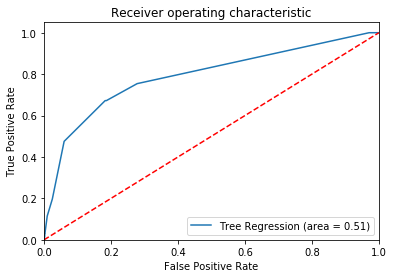

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

tree_roc_auc=roc_auc_score(y_test, model_dt.predict(x_test))

fpr, tpr, thresholds = roc_curve(y_test, model_dt.predict_proba(x_test)[:,1])

plt.figure()

plt.plot(fpr, tpr, label='Tree Regression (area = %0.2f)' % tree_roc_auc)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()